In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
train = pd.read_csv('../ventilator-pressure-prediction-data/train.csv')

In [43]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


Informationen über die Datentypen

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [45]:
train.isnull().any()

id           False
breath_id    False
R            False
C            False
time_step    False
u_in         False
u_out        False
pressure     False
dtype: bool

Hier sind Mittelwert und Standardabeichung wie in der Vorstellung der Daten zu sehen.

In [46]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [47]:
train['id'].duplicated().any()

False

**Individuelle Atemzüge**

Anzahl individueller Atemnzüge

In [48]:
unique_breaths = train['breath_id'].unique()
number_breaths = len(unique_breaths)
print(number_breaths)

75450


Mehrere Datenpunkte pro Atemzug

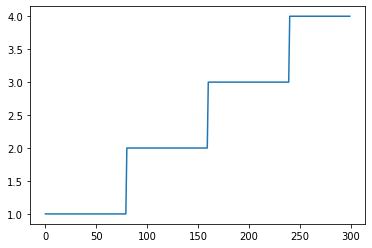

In [49]:
train['breath_id'][:300].plot();

Jeder Atemzug hat exakt 80 Datenpunkte

In [50]:
breath_lengths = train[['id','breath_id']].groupby('breath_id').count()['id']
breath_lengths.unique()

array([80])

Da alle Atemnzüge die selbe Länge haben, können wir diese als Konstate erstellen.

In [51]:
BREATH_LENGTH = breath_lengths.unique()[0]

**R und C, Lungeneigenschaften**

R und C sind inenrhalb eines Atemzuges kostant

In [52]:
r_c_std_in_breaths = train[['breath_id','R','C']].groupby('breath_id').std()
print(r_c_std_in_breaths['R'].unique())
print(r_c_std_in_breaths['C'].unique())

[0.]
[0.]


R hat 3 paarweise verschiedene Werte. Diese sind 5, 20 und 50, wie in der Datenvorstellung schon gesehen.

In [53]:
r_values = train[['breath_id', 'R']].groupby('breath_id').mean()['R']
print('Unique values:')
print(r_values.value_counts())

r_unique = np.sort(r_values.unique()).astype(int)

Unique values:
50    30126
5     24860
20    20464
Name: R, dtype: int64


C hat ebenfalls 3 paarweise verschiedene Werte. Diese sind 10, 20 und 50, wie in der Datenvorstellung schon gesehen. 

In [54]:
c_values = train[['breath_id', 'C']].groupby('breath_id').mean()['C']
print('Unique values:')
print(c_values.value_counts())

c_unique = np.sort(c_values.unique()).astype(int)

Unique values:
10    28059
50    24646
20    22745
Name: C, dtype: int64


Wie hängen nun die verschiedenen R und C Werte zusammen? 

Für R = 5 sind die drei C Werte gleichverteilt. 
Für R = 20 kommt C = 50 am häufigsten vor,
Für R = 50 ist C = 10 am häufigsten.

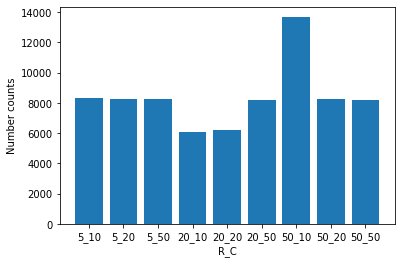

In [55]:
rc_values = np.array([
    [r, c, len(train[(train['R'] == r) & (train['C'] == c)])//BREATH_LENGTH] 
    for r in r_unique 
    for c in c_unique
])

x = range(len(rc_values))
plt.bar(x, rc_values[:,2])
plt.xticks(x, [str(r) + '_' + str(c) for r, c in rc_values[:,:2] ])
plt.xlabel('R_C')
plt.ylabel('Number counts')
plt.show()

Für C = 10 kommt R = 50 am häufigsten vor, 
Für C = 20 teilen sich R = 5 und R = 50 die meisten Counts, 
Für C = 50 sind die drei R Werte gleich verteilt.

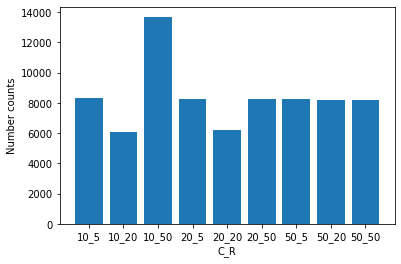

In [57]:
cr_values = np.array([
    [c, r, len(train[(train['C'] == c) & (train['R'] == r)])//BREATH_LENGTH] 
    for c in c_unique 
    for r in r_unique
])

x = range(len(cr_values))
plt.bar(x, cr_values[:,2])
plt.xticks(x, [str(c) + '_' + str(r) for c, r in cr_values[:,:2] ])
plt.xlabel('C_R')
plt.ylabel('Number counts')
plt.show()